CS 4375 - Final Project

**Author**: Alec Ibarra\
**Date**: 2024-10-30

In [1]:
# Install dependencies
%pip install --upgrade pip
%pip install ipykernel
%pip install matplotlib
%pip install pandas
%pip install scikit-learn
%pip install tensorflow[and-cuda]
%pip install keras-tuner
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import dependencies
import os
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import tensorflow as tf # type: ignore
import seaborn as sns # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.datasets import mnist # type: ignore
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from keras_tuner.tuners import Hyperband # type: ignore
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # type: ignore


2024-11-02 00:05:39.236762: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 00:05:41.269215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730523942.000321   29408 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730523942.192219   29408 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 00:05:44.045473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Tensorflow version
print(f"Tensorflow: v{tf.__version__}")

# Check GPU availability
print(f"GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
print(tf.config.list_physical_devices('GPU'))

Tensorflow: v2.18.0
GPUs Available: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape data to add a channel dimension, normalize pixel values
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Display some info and stats about the dataset
print(f'Training data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Number of classes: {y_train.shape[1]}')

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)
Number of classes: 10


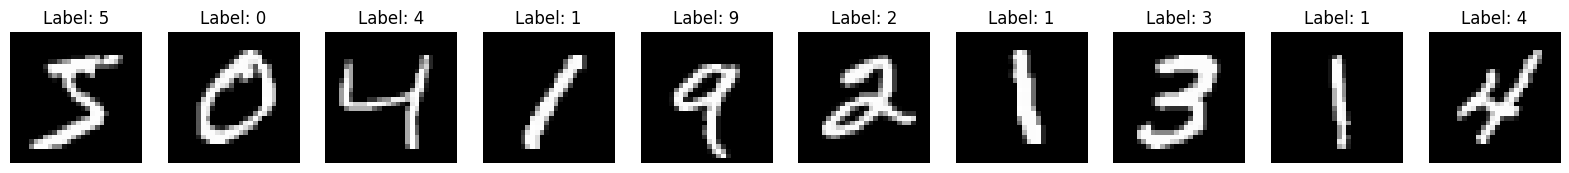

In [5]:
# Plot some data samples
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {np.argmax(y_train[i])}')
    ax.axis('off')

In [ ]:
# Set the batch size
batch_size = 256

# Define the CNN model for tuning
def create_model(hp):
    # Define a wider hyperparameter range for more comprehensive search
    conv1 = hp.Int('conv1', min_value=32, max_value=256, step=32)
    conv2 = hp.Int('conv2', min_value=32, max_value=256, step=32)
    dense_units = hp.Int('dense_units', min_value=32, max_value=256, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.9, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')
    
    # Build the model architecture
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(conv1, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(conv2, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])
    
    # Compile the model with the chosen learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Initialize the tuner
tuner = Hyperband(
    create_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=2,
    hyperband_iterations=5,
    directory='hyperband',
    project_name=f'mnist/{batch_size}_cnn_tuning'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

I0000 00:00:1730523967.074597   29408 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9702 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Reloading Tuner from hyperband/256_cnn_mnist_tuning/tuner0.json


In [7]:
# Start the search for the best hyperparameters
tuner.search(
    X_train,
    y_train,
    epochs=30,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Trial 460 Complete [00h 00m 40s]
val_accuracy: 0.9911666512489319

Best val_accuracy So Far: 0.9936666488647461
Total elapsed time: 02h 22m 35s


In [8]:
# Train the best model
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_trial.hyperparameters)
history = best_model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=batch_size,
).history

# Generate predictions for the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

Epoch 1/30


2024-11-02 00:39:57.951889: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[256,192,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,192,13,13]{3,2,1,0}, f32[192,192,3,3]{3,2,1,0}, f32[192]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8159 - loss: 0.5794

2024-11-02 00:40:04.888431: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[96,192,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,192,13,13]{3,2,1,0}, f32[192,192,3,3]{3,2,1,0}, f32[192]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8170 - loss: 0.5769

2024-11-02 00:40:06.377981: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[256,192,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,192,13,13]{3,2,1,0}, f32[192,192,3,3]{3,2,1,0}, f32[192]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-02 00:40:07.297558: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[16,192,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,192,13,13]{3,2,1,0}, f32[192,192,3,3]{3,2,1,0}, f32[192]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8174 - loss: 0.5757 - val_accuracy: 0.9819 - val_loss: 0.0571
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9749 - loss: 0.0811 - val_accuracy: 0.9874 - val_loss: 0.0363
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9842 - loss: 0.0523 - val_accuracy: 0.9905 - val_loss: 0.0296
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9873 - loss: 0.0420 - val_accuracy: 0.9905 - val_loss: 0.0266
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9895 - loss: 0.0353 - val_accuracy: 0.9910 - val_loss: 0.0262
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9913 - loss: 0.0281 - val_accuracy: 0.9924 - val_loss: 0.0220
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9926 - loss: 0.0243 - val_accuracy: 0.9919 - val_loss: 0.0225
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9935 - loss: 0.0206 - val_accuracy: 0.99

2024-11-02 00:42:10.748802: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,192,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,192,13,13]{3,2,1,0}, f32[192,192,3,3]{3,2,1,0}, f32[192]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


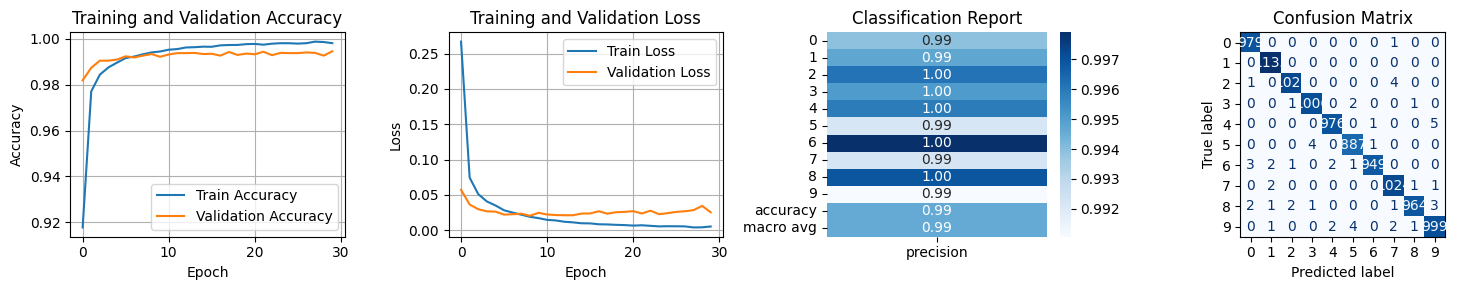

In [9]:
# Combined figure for accuracy, loss, and confusion matrix
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

# Best model's accuracy
axes[0].plot(history['accuracy'], label='Train Accuracy')
axes[0].plot(history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].set_title('Training and Validation Accuracy')
axes[0].grid(True)

# Best model's loss
axes[1].plot(history['loss'], label='Train Loss')
axes[1].plot(history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].set_title('Training and Validation Loss')
axes[1].grid(True)

# Best model's classification report
report = classification_report(y_true, y_pred_classes, output_dict=True)
df = pd.DataFrame(report).transpose()
sns.heatmap(df.iloc[:-1, :-3], annot=True, fmt=".2f", cmap='Blues', ax=axes[2])
axes[2].set_title('Classification Report')
axes[2].grid(False)

# Confusion matrix for the best model predictions
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues, ax=axes[3], colorbar=False)
axes[3].set_title('Confusion Matrix')
axes[3].grid(False)

# Adjust layout and display the figure
plt.tight_layout()

# Save the figure
os.makedirs('results', exist_ok=True)
plt.savefig(f'results/mnist/{batch_size}-best.png')

# Display the figure
plt.show()

In [10]:
# Extract all results from tuner
trials = tuner.oracle.get_best_trials(num_trials=9999)

# Create a DataFrame with trial IDs, hyperparameters, and scores
results_df = pd.DataFrame({
    'trial_id': [trial.trial_id for trial in trials],
    'mean_val_accuracy': [trial.score for trial in trials],
    'conv1': [trial.hyperparameters.values['conv1'] for trial in trials],
    'conv2': [trial.hyperparameters.values['conv2'] for trial in trials],
    'dense_units': [trial.hyperparameters.values['dense_units'] for trial in trials],
    'dropout_rate': [trial.hyperparameters.values['dropout_rate'] for trial in trials],
    'learning_rate': [trial.hyperparameters.values['learning_rate'] for trial in trials],
    'batch_size': batch_size,
})

# Save the results to a CSV file
os.makedirs('results', exist_ok=True)
results_df.to_csv(f'results/mnist/{batch_size}-all.csv', index=True)
results_df.head()

,trial_id,mean_val_accuracy,conv1,conv2,dense_units,dropout_rate,learning_rate,batch_size
0,0260,0.993667,192,192,256,0.5,0.000677,256
1,0426,0.993417,224,224,128,0.2,0.001523,256
2,0448,0.993417,224,256,160,0.6,0.000694,256
3,0130,0.993333,160,160,160,0.7,0.000959,256
4,0406,0.993167,256,256,160,0.6,0.000512,256
